# Simple Imitation Learning

In [11]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from models.mlp import MLP
from models.autoencoders import VAE
from trainers.standard import train
from utils_.utils import from_sim_get_poses_n_gripper
from utils_.plotting import plot_waypoints_and_initial_image
from utils_.waypoint_extraction import pickplace_task_waypoints

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")
DATA_PATH = "./datasets/sim_recs"
IMAGE_RESIZE = 256
LATENT_DIM = 16
DATAPOINT_COUNT = -1
AE_PATH = "./logs/models/VAE_2024-10-25_16:30/pth/epoch_400.pth"
L2W_PATH = "./logs/models/mlp_2024-10-21_16:47/pth/epoch_2000.pth"
dirs = os.listdir(DATA_PATH)
im_paths = [f"{DATA_PATH}/{dir}/images/0000.jpg" for dir in dirs]

Device Name: NVIDIA GeForce RTX 3090


In [13]:
image_encoder = VAE(latent_dim=LATENT_DIM).to(device=device)
image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))

# # Create the input data: latent representation of initial scene images
# X = []
# for i, im_path in tqdm(enumerate(im_paths)):
#     image = cv2.imread(im_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (IMAGE_RESIZE, IMAGE_RESIZE))
#     image = image/255.0
#     image = np.transpose(image, (2, 0, 1))  # HWC to CHW
#     latent, _ = image_encoder.encode(torch.Tensor(np.array([image])).to(device))
#     X.append(latent[0].cpu().detach().numpy())
#     if i == DATAPOINT_COUNT-1:
#         break

# X = np.array(X)
# np.save('./datasets/latent_to_waypoints/X.npy', X)
X = np.load('./datasets/latent_to_waypoints/X.npy')[:200]
print(X.shape)

(200, 16)


/tmp/ipykernel_17105/3727086397.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))


In [14]:
# # Create output data: waypoint collections from the paths
# ways = []
# for i, ep_path in tqdm(enumerate(dirs)):
#     pos, quat, gripper_widths = from_sim_get_poses_n_gripper(f"{DATA_PATH}/{ep_path}/proprioceptives.txt")
#     ways.append(pickplace_task_waypoints(pos, gripper_widths))
#     if i == DATAPOINT_COUNT-1:
#         break
# ways = np.array(ways)

# y = ways.reshape(ways.shape[0], -1)
# del ways
# np.save('./datasets/latent_to_waypoints/y.npy', y)
y = np.load('./datasets/latent_to_waypoints/y.npy')[:200]
print(y.shape)

(200, 9)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

errors = y_test - y_pred
errors = errors[:, :2]
errors = [np.linalg.norm(e) for e in errors]
mean_error = sum(errors)/len(errors)
devs = [abs(e-mean_error) for e in errors]
dev_error = sum(devs)/len(devs)

print("Avg. dist. from desired point (m): ", mean_error)
print("Avg. dev. from desired point (m): ", dev_error)

Avg. dist. from desired point (m):  0.12177853866339741
Avg. dev. from desired point (m):  0.04526984373333229


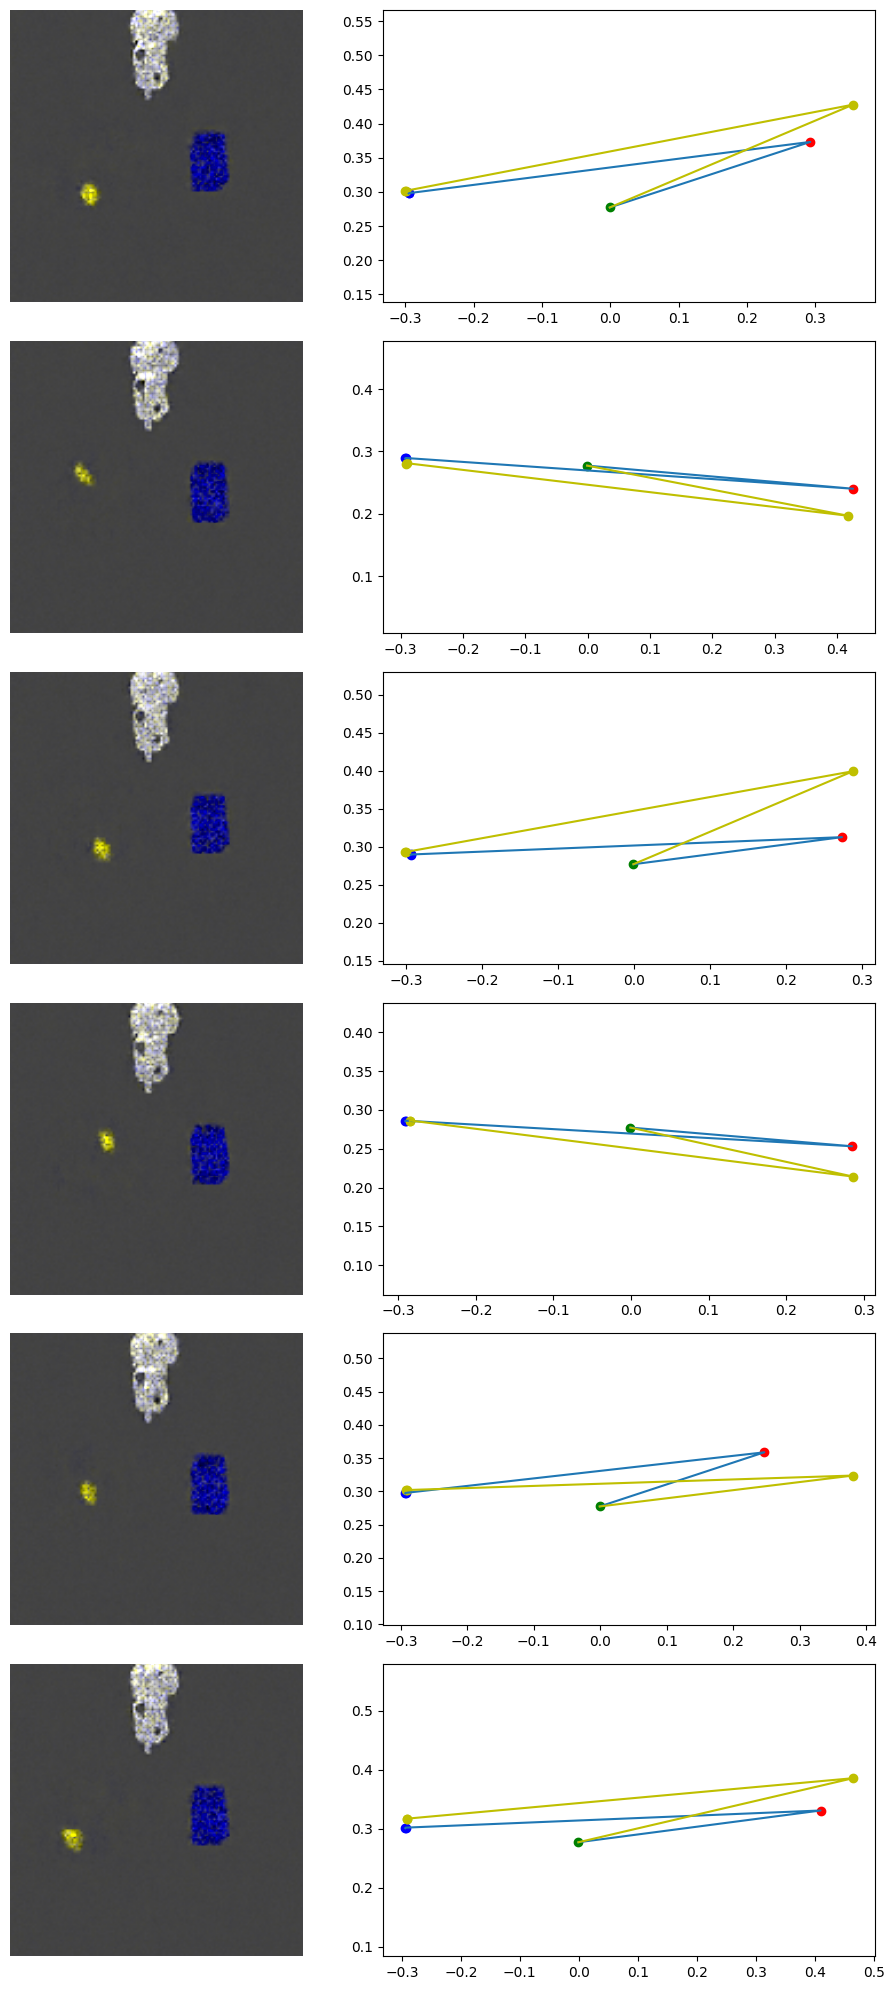

In [16]:
example_count = 6
rand_indices = np.random.choice(list(range(len(X_test))), size=example_count)

latent = X_test[rand_indices]
imgs = image_encoder.decode(torch.Tensor(latent).to(device))
imgs = imgs.detach().cpu().numpy()
imgs = np.maximum(imgs, 0)
imgs = np.minimum(imgs, 1)
imgs = np.transpose(imgs, (0, 2, 3, 1))

target_waypoints = y_test[rand_indices].reshape(6, 3, 3)

pred_waypoints = ridge_model.predict(latent)
pred_waypoints = pred_waypoints.reshape(6, 3, 3)

plot_waypoints_and_initial_image(pred_waypoints, target_waypoints, imgs)

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_test, dtype=torch.float)
y_val_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [18]:
mlp_model = MLP(X_train.shape[1], y_train.shape[1], hidden_layers=[1028, 256, 128]).to(device)
# mlp_model.load_state_dict(torch.load(L2W_PATH, map_location=device))
mlp_model = train(mlp_model, device, train_loader, val_loader, n_epochs=10000, lr=1e-4)

Epoch 1,	 Train Loss: 0.364848,	 Val Loss: 0.361361
Epoch 2,	 Train Loss: 0.355482,	 Val Loss: 0.351366
Epoch 3,	 Train Loss: 0.346006,	 Val Loss: 0.341218
Epoch 4,	 Train Loss: 0.333288,	 Val Loss: 0.330798
Epoch 5,	 Train Loss: 0.326329,	 Val Loss: 0.320002
Epoch 6,	 Train Loss: 0.313102,	 Val Loss: 0.308657
Epoch 7,	 Train Loss: 0.302394,	 Val Loss: 0.296705
Epoch 8,	 Train Loss: 0.290362,	 Val Loss: 0.284136
Epoch 9,	 Train Loss: 0.274438,	 Val Loss: 0.270843
Epoch 10,	 Train Loss: 0.265222,	 Val Loss: 0.256796
Epoch 11,	 Train Loss: 0.246859,	 Val Loss: 0.242004
Epoch 12,	 Train Loss: 0.232378,	 Val Loss: 0.226435
Epoch 13,	 Train Loss: 0.216889,	 Val Loss: 0.210102
Epoch 14,	 Train Loss: 0.200722,	 Val Loss: 0.193145
Epoch 15,	 Train Loss: 0.180644,	 Val Loss: 0.175701
Epoch 16,	 Train Loss: 0.166518,	 Val Loss: 0.157967
Epoch 17,	 Train Loss: 0.148777,	 Val Loss: 0.140089
Epoch 18,	 Train Loss: 0.130235,	 Val Loss: 0.122282
Epoch 19,	 Train Loss: 0.112108,	 Val Loss: 0.104887
Ep

In [21]:
y_pred = mlp_model(torch.Tensor(X_test).to(device)).cpu().detach().numpy()

for i in range(2):
    if i:
        y_pred = mlp_model(torch.Tensor(X_test).to(device)).cpu().detach().numpy()
        errors = y_test - y_pred
    else:
        y_pred = mlp_model(torch.Tensor(X_train).to(device)).cpu().detach().numpy()
        errors = y_train - y_pred
    
    errors = errors[:, :2]
    errors = [np.linalg.norm(e) for e in errors]
    mean_error = sum(errors)/len(errors)
    devs = [abs(e-mean_error) for e in errors]
    dev_error = sum(devs)/len(devs)

    max_error = .015
    total_wins = 0
    for e in errors:
        if e < max_error:
            total_wins += 1

    if i:
        print("Test avg. dist. from desired point (m): ", mean_error)
        print("Test avg. dev. from desired point (m): ", dev_error)
        print(f"Success rate: {(total_wins/len(errors)*100):.2f}%")
    else:
        print("Train avg. dist. from desired point (m): ", mean_error)
        print("Train avg. dev. from desired point (m): ", dev_error)
    print("+--------------------------------------------------------------+")

Train avg. dist. from desired point (m):  0.008022962565085504
Train avg. dev. from desired point (m):  0.003689678963773485
+--------------------------------------------------------------+
Test avg. dist. from desired point (m):  0.01973720962343909
Test avg. dev. from desired point (m):  0.012230194499485267
Success rate: 45.00%
+--------------------------------------------------------------+


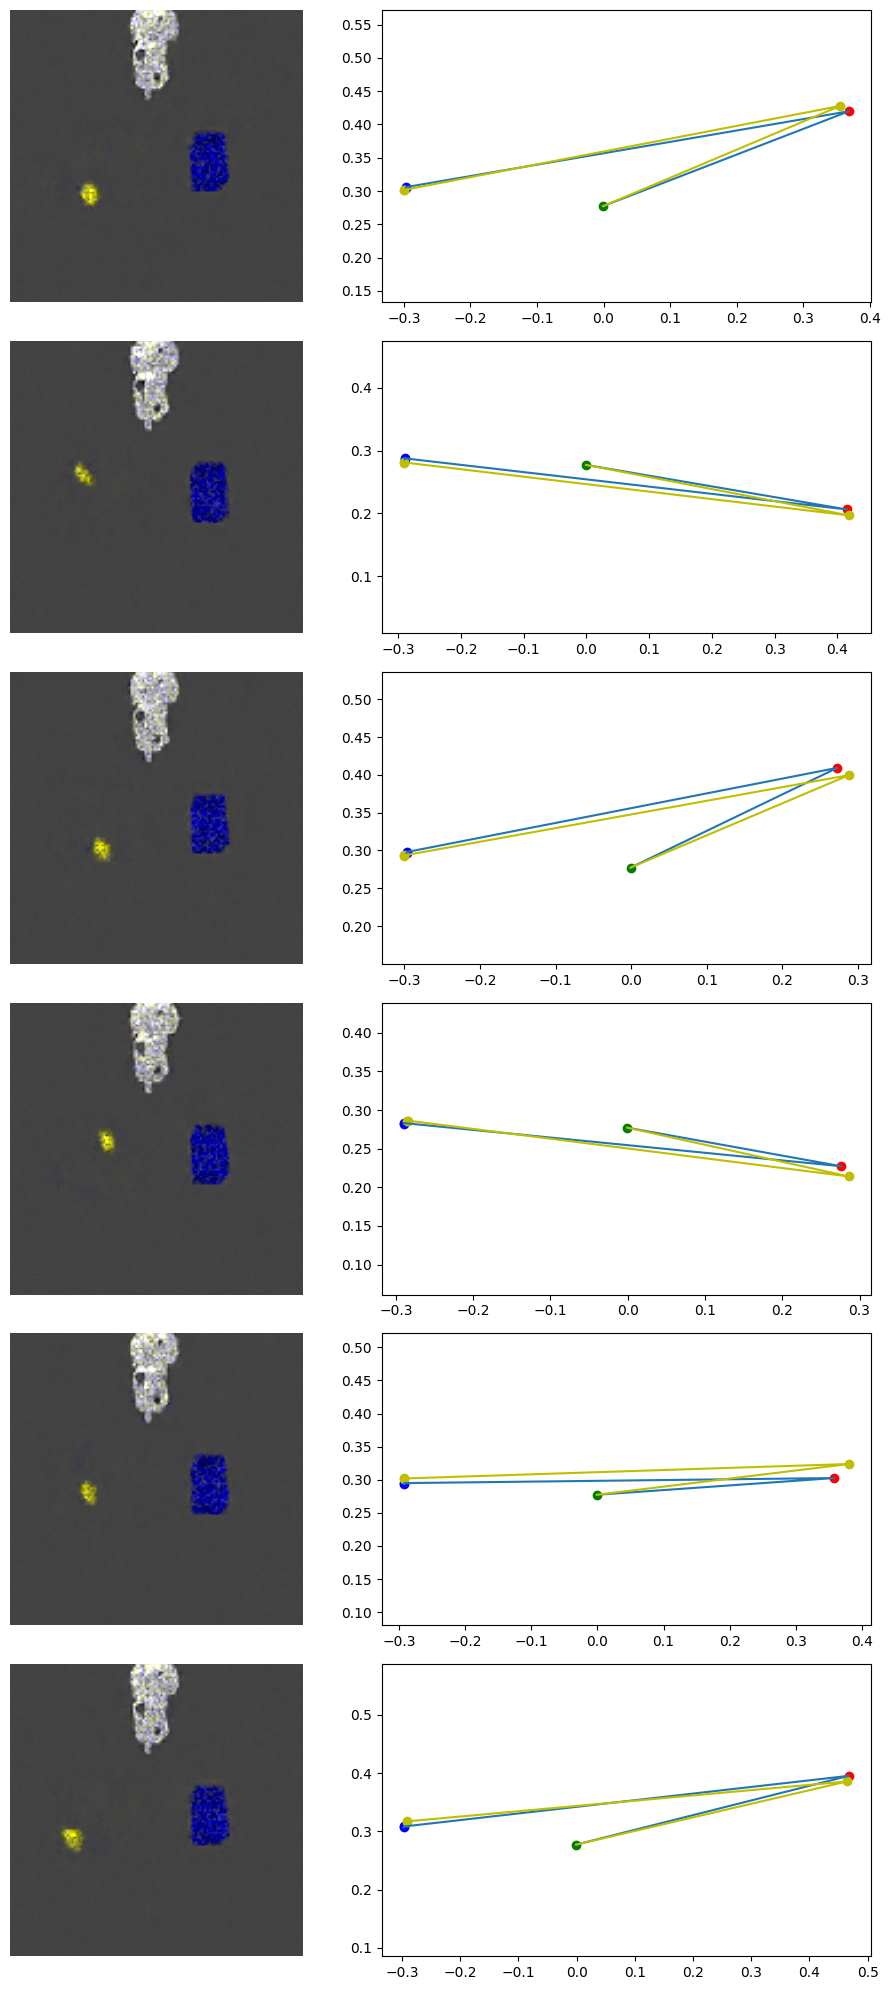

In [20]:
pred_waypoints = mlp_model(torch.Tensor(latent).to(device)).cpu().detach().numpy()
pred_waypoints = pred_waypoints.reshape(6, 3, 3)

plot_waypoints_and_initial_image(pred_waypoints, target_waypoints, imgs, save_path=f"{mlp_model.path}/results.png")